In [4]:
import pandas as pd

In [5]:
df_bagerhat = pd.read_csv('Bagerhat_historical_weather_1980_2024.csv')

In [6]:
shape = df_bagerhat.shape
print(f"Dataset contains {shape[0]} rows and {shape[1]} columns.")

Dataset contains 16437 rows and 15 columns.


In [7]:
df_bagerhat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16437 entries, 0 to 16436
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   district                       16437 non-null  object 
 1   day                            16437 non-null  int64  
 2   month                          16437 non-null  int64  
 3   year                           16437 non-null  int64  
 4   temperature(degree C)          10478 non-null  float64
 5   feels_like(degree C)           10478 non-null  float64
 6   max_temperature(degree C)      14991 non-null  float64
 7   minimum_temperature(degree C)  14991 non-null  float64
 8   humidity                       10478 non-null  float64
 9   precipitation                  5479 non-null   float64
 10  windspeed                      11924 non-null  float64
 11  atmospheric_pressure           7115 non-null   float64
 12  UV                             4038 non-null  

In [8]:
import pandas as pd

df = df_bagerhat.copy()

# Build datetime index
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').set_index('date')

# Define feature groups
core_cols = [
    'temperature(degree C)', 'feels_like(degree C)',
    'max_temperature(degree C)', 'minimum_temperature(degree C)',
    'humidity', 'windspeed', 'atmospheric_pressure', 'dew_point'
]

optional_cols = ['precipitation', 'UV', 'solar_radiation']

# ---- Step 1: Handle missing gaps for core variables ----
mask = df[core_cols].isna().any(axis=1)
group = (mask != mask.shift()).cumsum()
gap_lengths = mask.groupby(group).transform('sum')

# Drop long missing sequences (≥6 days)
df = df[~((mask) & (gap_lengths >= 6))]

# ---- Step 2: Interpolate ----
# Interpolate core features with time-based interpolation
df[core_cols] = df[core_cols].interpolate(method='time')

# Interpolate optional ones separately, if they exist
for col in optional_cols:
    if col in df.columns:
        df[col] = df[col].interpolate(method='time', limit_direction='both')

# ---- Step 3: Drop rows only if core variables still missing ----
df = df.dropna(subset=core_cols)

# ---- Step 4: Summary ----
print(f"After cleaning, dataset contains {df.shape[0]} rows and {df.shape[1]} columns out of {df_bagerhat.shape[0]} rows. (taking precipitation as optional)")
missing_ratio = df.isna().mean().round(3) * 100
print("\nRemaining missing % per column:")
print(missing_ratio)


After cleaning, dataset contains 7303 rows and 15 columns out of 16437 rows. (taking precipitation as optional)

Remaining missing % per column:
district                         0.0
day                              0.0
month                            0.0
year                             0.0
temperature(degree C)            0.0
feels_like(degree C)             0.0
max_temperature(degree C)        0.0
minimum_temperature(degree C)    0.0
humidity                         0.0
precipitation                    0.0
windspeed                        0.0
atmospheric_pressure             0.0
UV                               0.0
solar_radiation                  0.0
dew_point                        0.0
dtype: float64


In [9]:
long_gaps = gap_lengths[mask & (gap_lengths >= 6)]
print(f"Dropped {long_gaps.nunique()} long missing sequences (≥6 days).")

Dropped 48 long missing sequences (≥6 days).


Date range: 1980-01-01 to 2024-12-31


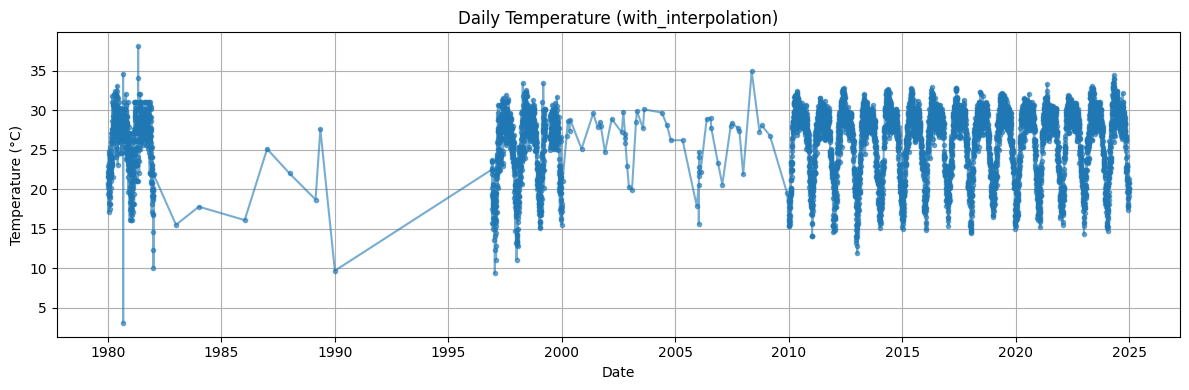

C:\Users\Khalid\AppData\Local\Temp\ipykernel_5988\1377963962.py:28: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_avg = with_interpolation.set_index('date')['temperature(degree C)'].resample('M').mean()


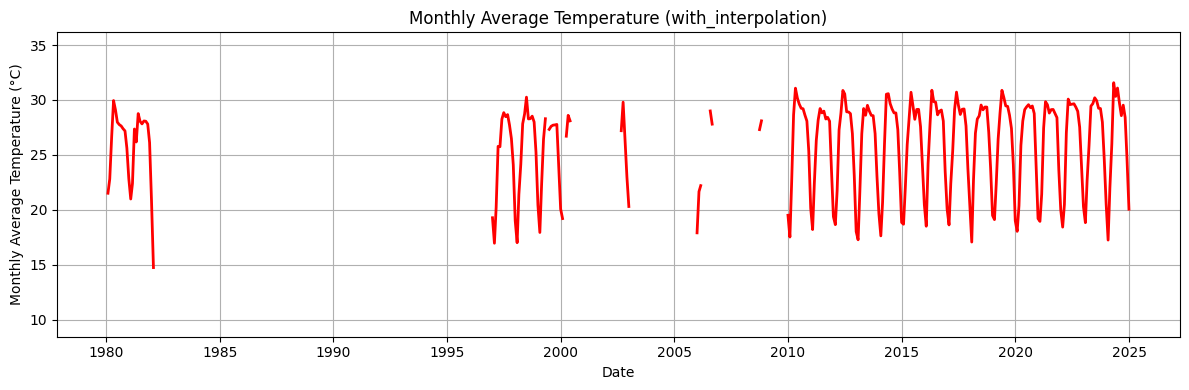

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# assuming your cleaned + interpolated DataFrame is named 'df'
with_interpolation = df.copy()

# ensure datetime column exists (if not already index)
if 'date' not in with_interpolation.columns:
    with_interpolation['date'] = pd.to_datetime(with_interpolation[['year', 'month', 'day']])

# show date range
min_date = with_interpolation['date'].min()
max_date = with_interpolation['date'].max()
print(f"Date range: {min_date.date()} to {max_date.date()}")

# --- Plot 1: Daily Temperature (interpolated) ---
plt.figure(figsize=(12, 4))
plt.plot(with_interpolation['date'], with_interpolation['temperature(degree C)'],
         marker='.', linestyle='-', alpha=0.6, color='tab:blue')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Daily Temperature (with_interpolation)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Monthly Average Temperature (interpolated) ---
monthly_avg = with_interpolation.set_index('date')['temperature(degree C)'].resample('M').mean()

plt.figure(figsize=(12, 4))
plt.plot(monthly_avg.index, monthly_avg.values, color='red', linewidth=2)
plt.xlabel('Date')
plt.ylabel('Monthly Average Temperature (°C)')
plt.title('Monthly Average Temperature (with_interpolation)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# show info and then display all rows/columns
with_interpolation.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7303 entries, 1980-01-01 to 2024-12-31
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   district                       7303 non-null   object        
 1   day                            7303 non-null   int64         
 2   month                          7303 non-null   int64         
 3   year                           7303 non-null   int64         
 4   temperature(degree C)          7303 non-null   float64       
 5   feels_like(degree C)           7303 non-null   float64       
 6   max_temperature(degree C)      7303 non-null   float64       
 7   minimum_temperature(degree C)  7303 non-null   float64       
 8   humidity                       7303 non-null   float64       
 9   precipitation                  7303 non-null   float64       
 10  windspeed                      7303 non-null   float64       
 11 

In [14]:
# Find dates where columns have value exactly zero and print them per column.
# Uses existing `df` in the notebook.

# consider only numeric columns
num_cols = df.select_dtypes(include='number').columns.tolist()

zero_dates = {}
for c in num_cols:
    mask = df[c] == 0
    if mask.any():
        # format dates as YYYY-MM-DD strings
        zero_dates[c] = df.index[mask].strftime('%Y-%m-%d').tolist()

if not zero_dates:
    print("No zero values found in numeric columns.")
else:
    for col, dates in zero_dates.items():
        print(f"{col} ({len(dates)} occurrences):")
        print(", ".join(dates))
        print()

precipitation (2260 occurrences):
2010-01-01, 2010-01-02, 2010-01-03, 2010-01-04, 2010-01-05, 2010-01-06, 2010-01-07, 2010-01-08, 2010-01-09, 2010-01-10, 2010-01-11, 2010-01-12, 2010-01-13, 2010-01-15, 2010-01-16, 2010-01-17, 2010-01-18, 2010-01-19, 2010-01-20, 2010-01-21, 2010-01-22, 2010-01-23, 2010-01-24, 2010-01-25, 2010-01-26, 2010-01-27, 2010-01-28, 2010-01-29, 2010-01-30, 2010-01-31, 2010-02-01, 2010-02-02, 2010-02-03, 2010-02-04, 2010-02-05, 2010-02-06, 2010-02-07, 2010-02-08, 2010-02-09, 2010-02-10, 2010-02-11, 2010-02-12, 2010-02-13, 2010-02-14, 2010-02-15, 2010-02-16, 2010-02-19, 2010-02-20, 2010-02-21, 2010-02-22, 2010-02-23, 2010-02-27, 2010-02-28, 2010-03-01, 2010-03-02, 2010-03-03, 2010-03-04, 2010-03-06, 2010-03-07, 2010-03-08, 2010-03-09, 2010-03-10, 2010-03-11, 2010-03-12, 2010-03-13, 2010-03-18, 2010-03-19, 2010-03-20, 2010-03-21, 2010-03-22, 2010-03-23, 2010-03-24, 2010-03-25, 2010-03-26, 2010-03-27, 2010-03-28, 2010-03-31, 2010-04-03, 2010-04-04, 2010-04-05, 2010-0

In [12]:

df = df_bagerhat.copy()

# Build datetime index
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.sort_values('date').set_index('date')

# Define feature groups
core_cols = [
    'temperature(degree C)', 'feels_like(degree C)',
    'max_temperature(degree C)', 'minimum_temperature(degree C)',
    'humidity', 'windspeed', 'precipitation','atmospheric_pressure', 'dew_point'
]

optional_cols = [ 'UV', 'solar_radiation']

# ---- Step 1: Handle missing gaps for core variables ----
mask = df[core_cols].isna().any(axis=1)
group = (mask != mask.shift()).cumsum()
gap_lengths = mask.groupby(group).transform('sum')

# Drop long missing sequences (≥6 days)
df = df[~((mask) & (gap_lengths >= 6))]

# ---- Step 2: Interpolate ----
# Interpolate core features with time-based interpolation
df[core_cols] = df[core_cols].interpolate(method='time')

# Interpolate optional ones separately, if they exist
for col in optional_cols:
    if col in df.columns:
        df[col] = df[col].interpolate(method='time', limit_direction='both')

# ---- Step 3: Drop rows only if core variables still missing ----
df = df.dropna(subset=core_cols)

# ---- Step 4: Summary ----
print(f"After cleaning, dataset contains {df.shape[0]} rows and {df.shape[1]} columns out of {df_bagerhat.shape[0]} rows. (taking precipitation as mandatory)")
missing_ratio = df.isna().mean().round(3) * 100
print("\nRemaining missing % per column:")
print(missing_ratio)


After cleaning, dataset contains 5479 rows and 15 columns out of 16437 rows. (taking precipitation as mandatory)

Remaining missing % per column:
district                         0.0
day                              0.0
month                            0.0
year                             0.0
temperature(degree C)            0.0
feels_like(degree C)             0.0
max_temperature(degree C)        0.0
minimum_temperature(degree C)    0.0
humidity                         0.0
precipitation                    0.0
windspeed                        0.0
atmospheric_pressure             0.0
UV                               0.0
solar_radiation                  0.0
dew_point                        0.0
dtype: float64


In [13]:
long_gaps = gap_lengths[mask & (gap_lengths >= 6)]
print(f"Dropped {long_gaps.nunique()} long missing sequences (≥6 days).")

Dropped 1 long missing sequences (≥6 days).
